In [1]:
import pickle
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, Dropout, LSTM
from tensorflow.keras import Model
from tensorflow.keras.backend import ctc_decode
from tensorflow.keras.layers import Layer

In [2]:
with open('./imgtensor_sh.pkl','rb') as arrbee:
    img_tensor_sh = pickle.load(arrbee)

In [3]:
with open('./labeltensor_shpad.pkl','rb') as ry:
    lab_tensor_sh = pickle.load(ry)

In [4]:
charlist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,-+1234567890'

In [ ]:
tf.cast()

In [49]:
lab_tensor_sh[0]

<tf.Tensor: shape=(37,), dtype=int32, numpy=
array([19, 31, 29, 44, 31, 46, 27, 44, 51,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])>

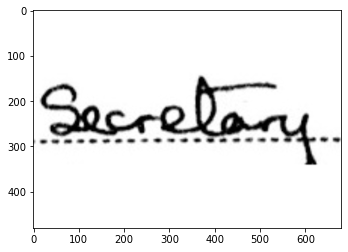

In [93]:
plt.imshow(img_tensor_sh[0].numpy(), cmap='gray')

In [92]:
[charlist[l-1] for l in lab_tensor_sh[0].numpy() if l>0]

['S', 'e', 'c', 'r', 'e', 't', 'a', 'r', 'y']

In [51]:
tf.math.count_nonzero(lab_tensor_sh,axis=-1,keepdims=True)

<tf.Tensor: shape=(1407, 1), dtype=int64, numpy=
array([[ 9],
       [ 3],
       [12],
       ...,
       [ 1],
       [13],
       [10]], dtype=int64)>

In [102]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


In [10]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.math.count_nonzero(y_true,axis=-1,keepdims=True), dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [11]:
input_img = Input(shape=(480,679,1),name='image',dtype="float32")
#labels = Input(shape=(None,),name='label',dtype="int32") #we're using ragged tensors, so no set shape

x = Conv2D(32,(3,3),activation='relu',name='Conv1')(input_img)
x = MaxPooling2D((2,2), name = "pool1")(x)

x = Conv2D(64,(3,3),activation='relu',name='Conv2')(x)
x = MaxPooling2D((2,2), name = "pool2")(x)

shape = ((480//4)-2,((679//4)-1)*64)

x = Reshape(target_shape=shape, name = 'reshape')(x)
x = Dense(64, activation='relu', name ='dense1')(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(128,return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(x)


#x = Dense(len(charlist)+2,activation='softmax',name='dense2')(x)
output = Dense(len(charlist)+2,activation='softmax',name='dense2')(x)
#output = CTCLayer(name='ctc_loss')(labels,x)

model = Model(input_img,output,name='basic-OCR')
model.compile(optimizer='adam',loss=CTCLoss)


In [ ]:
model.summary()

In [120]:
train_ds = tf.data.Dataset.from_tensor_slices((img_tensor_sh[:100],lab_tensor_sh[:100]))

In [119]:
val_ds = tf.data.Dataset.from_tensor_slices((img_tensor_sh[100:120],lab_tensor_sh[100:120]))

In [7]:
lab_arr_sh = [[l for l in lab.numpy() if l>0] for lab in lab_tensor_sh]

In [12]:
eps = 10
history = model.fit(img_tensor_sh[:100],lab_arr_sh[:100]
                    ,validation_data=(img_tensor_sh[100:120],lab_arr_sh[100:120]),epochs=eps)

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.framework.ops.EagerTensor'>, (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'numpy.int32\'>"})'})

In [130]:
prediction_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)

In [140]:
preds = prediction_model.predict(img_tensor_sh[100:120])

In [25]:
tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[1400:1405]])

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([10,  6,  1,  7,  1])>

In [141]:
pred_texts = ctc_decode(preds,
                        tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[100:120]]),
                       greedy=True)

In [143]:
pred_texts[0][0]

<tf.Tensor: shape=(20, 118), dtype=int64, numpy=
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int64)>

In [145]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(charlist))

In [149]:
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),invert=True)

In [13]:
lab_sh = [''.join([charlist[let-1] for let in lab.numpy() if let>0]) for lab in lab_tensor_sh]